# Python Visualization
Python code for visualization.  Feel free to re-use at will.

Download the [jupyter notebook](https://github.com/jpchen/makeplot/blob/master/plots.ipynb) on **[Github](https://github.com/jpchen/makeplot)**.

1. [Matplotlib](#Matplotlib-Pyplot)
  1. [Line Plot (functions)](#Line-Plot)
  2. [Countour](#Countour-Plot)
  3. [Heatmap](#Heatmap)
  4. [3d](#3D-Plots)
  5. [Vector Fields](#Vector-Fields)
  6. [Gaussian Processes](#Gaussian-Processes)
2. [Seaborn](#Seaborn)
  1. [Scatter](#Scatter-Plot)
  2. [Histogram](#Histogram)
  3. [Density](#Density-Plot)

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

## Matplotlib - Pyplot

### Line Plot

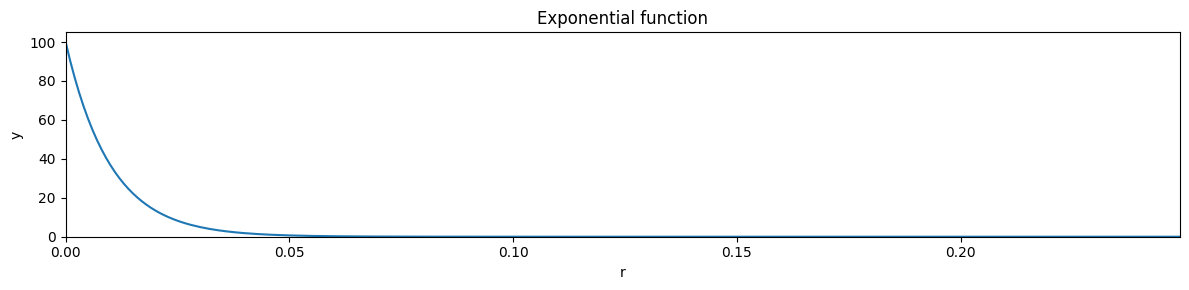

In [13]:
# ---- load data ----
# note this uses pytorch and pyro to plot distributions, but can be replaced
# with any other data
import torch
import pyro
import pyro.distributions as dist

radii = torch.arange(0, 0.25, 0.001).detach()
d = dist.Exponential(1 / 1e-2)
prob = d.log_prob(radii).detach().exp()
plt.figure(figsize=(12, 3), dpi=100).patch.set_color('white')
plt.plot(radii.numpy(), prob.numpy())
plt.xlim(0, radii.numpy().max())
plt.ylim(0, prob.numpy().max() * 1.05)
plt.xlabel('r')
plt.ylabel('y')
plt.title('Exponential function')
plt.tight_layout();

### Countour Plot

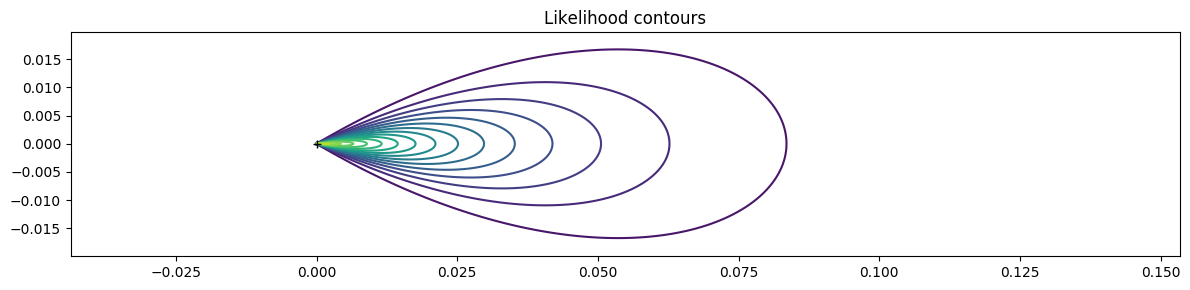

In [12]:
# ---- load data ----
# note this uses pytorch and pyro to plot distributions, but can be replaced
# with any other data
import torch
import pyro
import pyro.distributions as dist

X = torch.arange(-0.01, 0.12, 0.0002).unsqueeze(-1)
Y = torch.arange(-0.02, 0.02, 0.0002).unsqueeze(0)
shape = torch.Size((X.shape[0], Y.shape[1]))
X = X.expand(shape)
Y = Y.expand(shape)
radius = (X**2 + Y**2).sqrt()
angle = torch.atan2(Y, X)

log_prob1 = dist.Exponential(1.0 / 0.015).log_prob(radius)
log_prob2 = dist.VonMises(0.0, 40).log_prob(angle)
Z = (log_prob1 + log_prob2).exp().sqrt()
plt.figure(figsize=(12, 3), dpi=100).patch.set_color('white')
plt.contour(X.numpy(), Y.numpy(), Z.numpy(), 20)
plt.plot([0], [0], 'k+')
plt.axis('equal')
plt.title('Likelihood contours')
plt.tight_layout();

### Heatmap

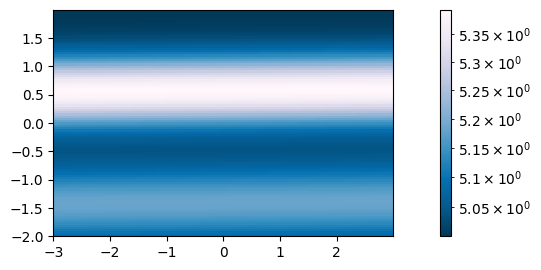

In [15]:
import torch
import pyro.distributions as dist
from matplotlib.colors import LogNorm

N = 10000
x = torch.arange(-3, 3, 6/N).unsqueeze(-1)
y = torch.arange(-2, 2, 4/N).unsqueeze(-1)
data = torch.cat((x, y), dim=-1)

# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale so we see both hump and spike.  linear
# scale only shows the spike.
mu = torch.tensor([-0.8, -0.2]).unsqueeze(0)
sigma = torch.tensor([[0.4, 0.3],[0.3, 0.5]]).unsqueeze(0)
z = dist.MultivariateNormal(mu.expand(N, -1), sigma.expand(N, -1, -1)).log_prob(data).exp().numpy()
mu = torch.tensor([2., 1.5]).unsqueeze(0)
sigma = torch.tensor([[0.7, 0.4],[0.2, 0.3]]).unsqueeze(0)
z1 = dist.MultivariateNormal(mu.expand(N, -1), sigma.expand(N, -1, -1)).log_prob(data).exp().numpy()
z = z + 0.5*z1
x, y = x.numpy(), y.numpy()
n = int(N/100)
z = z.reshape(n, n)

plt.figure(figsize=(12, 3), dpi=100).patch.set_color('white')
plt.imshow(z+5, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
        cmap='PuBu_r', norm=LogNorm())
plt.colorbar()

### 3D Plots

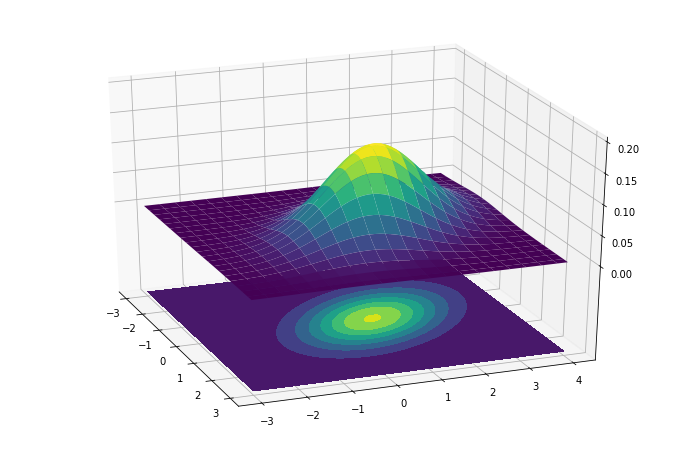

In [16]:
import torch
import pyro.distributions as dist

# data
# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = torch.tensor([0., 1.])
Sigma = torch.tensor([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = torch.empty(X.shape + (2,))
pos[:, :, 0] = torch.from_numpy(X)
pos[:, :, 1] = torch.from_numpy(Y)

# The distribution on the variables X, Y packed into pos.
Z = dist.MultivariateNormal(mu, Sigma).log_prob(pos).exp().numpy()

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)


### Vector Fields

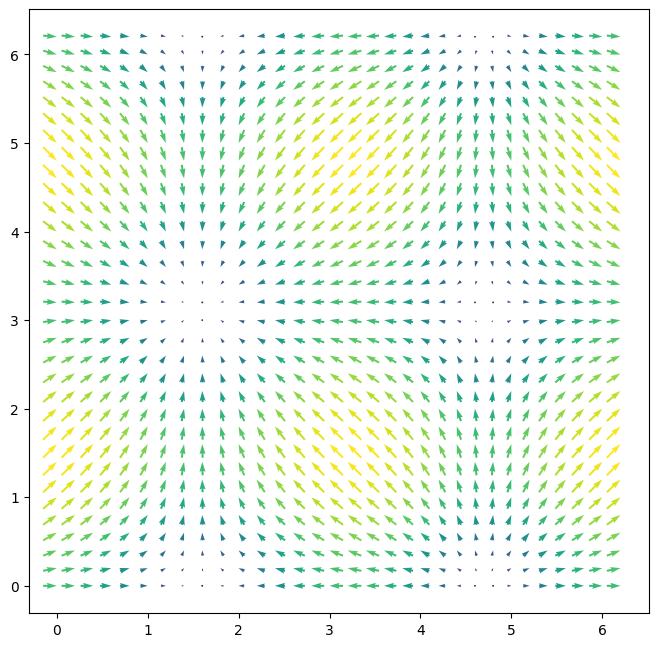

In [18]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
M = np.hypot(np.cos(X), np.sin(Y))  # determines the colors based on the hypotenuse
plt.figure(figsize=(8, 8), dpi=100).patch.set_color('white')
Q = plt.quiver(X, Y, np.cos(X), np.sin(Y), M, units='x', pivot='tip', width=0.022,
               scale=1 / 0.15)
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')

### Gaussian Processes

In [20]:
# code borrowed from http://pyro.ai/examples/bo.html
import json

with open('gp_data.json', 'r') as f:
    data = json.load(f)
x, y, loc, var = map(data.__getitem__, ['x', 'y', 'loc', 'var'])
x, y, loc, var = map(np.array, [x, y, loc, var])
Xnew = torch.linspace(-0.1, 1.1)
plt.figure(figsize=(12, 3), dpi=100).patch.set_color('white')
plt.plot(x, y, "kx")  # plot all observed data
with torch.no_grad():
    sd = np.sqrt(var)
    plt.plot(Xnew.numpy(), loc, "r", lw=2)  # plot predictive mean
    plt.fill_between(Xnew.numpy(), loc - 2*sd, loc + 2*sd,
                     color="C0", alpha=0.3)  # plot uncertainty intervals
plt.title("Gaussian Process Regression")

FileNotFoundError: [Errno 2] No such file or directory: 'gp_data.json'

## Seaborn

### Scatter Plot

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

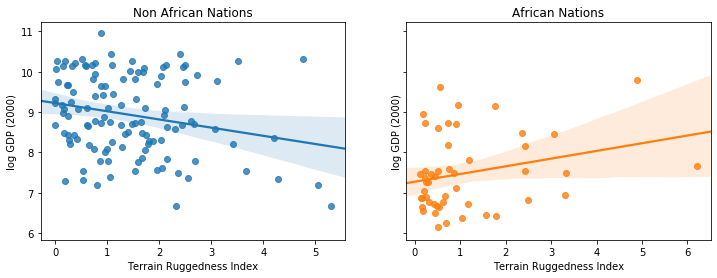

In [22]:
# --- load data ---
# note this uses panda to load real data, but can be replaced with anything
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
# -------------

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
african_nations = rugged_data[rugged_data["cont_africa"] == 1]
non_african_nations = rugged_data[rugged_data["cont_africa"] == 0]
sns.regplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.regplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

### Histogram

In [23]:
# data loading
hmc_empirical = np.load('hmc_data.npy')
svi_diagnorm_empirical = np.load('svi_data.npy')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_diagnorm_empirical[:, i], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_empirical[:, i], ax=ax, label="HMC")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

FileNotFoundError: [Errno 2] No such file or directory: 'hmc_data.npy'

### Density Plot

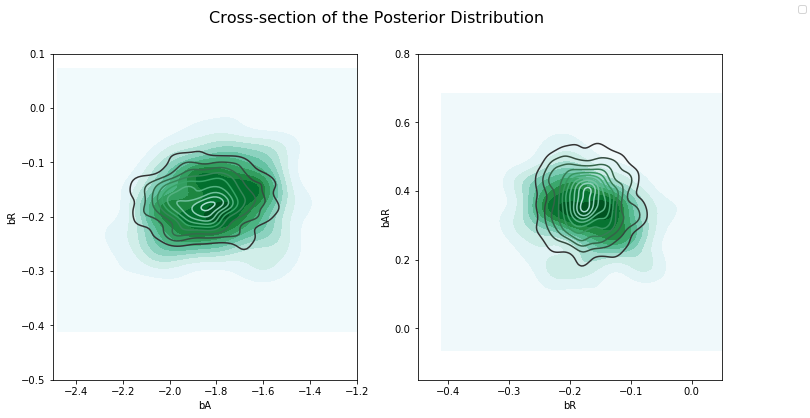

In [10]:
# data loading
hmc_empirical = np.load('hmc_data.npy')
svi_diagnorm_empirical = np.load('svi_data.npy')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_empirical[:, 1], hmc_empirical[:, 2], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 1], svi_diagnorm_empirical[:, 2], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_empirical[:, 2], hmc_empirical[:, 3], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_diagnorm_empirical[:, 2], svi_diagnorm_empirical[:, 3], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

[About me](http://jonathanpchen.com)